# Stochastic Gradient Descent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
import utils
%matplotlib inline

We retrace the steps from the gradient descent notebook. We will start with first 100 rows of data.

In [2]:
data = np.load("sgd_data.npy").astype('float32')
rxs = data[:100,0]
rys = data[:100,1]

and displaying it:

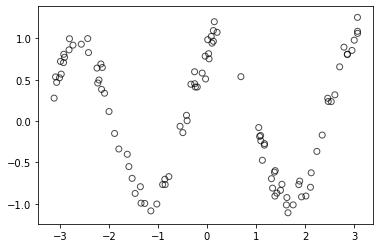

In [3]:
plt.scatter(rxs,rys, alpha=0.7, color='none', edgecolor="black");

In [4]:
def fitf(x,o,t):
    return np.sin(x*o+t)

def fitf_tensor(x,o,t):
    return np.moveaxis(np.sin(np.tensordot(np.atleast_1d(x),o,0)+t),0,-1)

def mse(f, x, y, o, t):
        err = f(x,o,t)-y
        return 0.5*np.sum(err*err, axis=-1)/len(x)

In [5]:
grid_size = 400
os = np.linspace(0, 7, grid_size)
ts = np.linspace(-np.pi,np.pi,grid_size)
otg = np.meshgrid(os,ts)

vg = mse(fitf_tensor, rxs, rys, otg[0], otg[1])

In [6]:
def grad(x,y, o, t):
    return np.array((
        -2*np.sum((y-np.sin(o*x+t))*np.cos(o*x+t)*x),
        -2*np.sum((y-np.sin(o*x+t))*np.cos(o*x+t))
    ))/len(x)

In [7]:
t_rxs = torch.from_numpy(rxs)
t_rys = torch.from_numpy(rys)

In [22]:
p = torch.FloatTensor([3,1])
p.requires_grad_(True);

In [9]:
gd = torch.optim.SGD([p], lr=0.1)

In [10]:
loss_f = torch.nn.MSELoss()

In [11]:
%%time
fig_gd, ax =  plt.subplots(1,2,figsize=(16,8))
ax[0].contourf(otg[0], otg[1],vg, levels=20)
ax[0].scatter([p[0].item()], [p[1].item()],c='none', s=20, edgecolor='red')
eta = 0.1
trajectory_list=[]
n_iter = 50
for i in range(n_iter):
    gd.zero_grad()
    prediction = torch.sin(t_rxs*p[0]+p[1])
    loss = loss_f(prediction, t_rys)
    loss.backward()
    gd.step()
    np_p = p.detach().numpy()
    trajectory_list.append(np.concatenate((p.grad.numpy(),np_p,[mse(fitf,rxs, rys,*np_p)])))
    ax[0].scatter([np_p[0]], [np_p[1]],c='red', s=20, edgecolor='red')

trajectory_gd=np.stack(trajectory_list)
utils.plot_grad_and_trajectory(ax[1], trajectory_gd)
ax[1].set_xlabel("epoch")
plt.close()

CPU times: user 922 ms, sys: 11.1 ms, total: 933 ms
Wall time: 156 ms


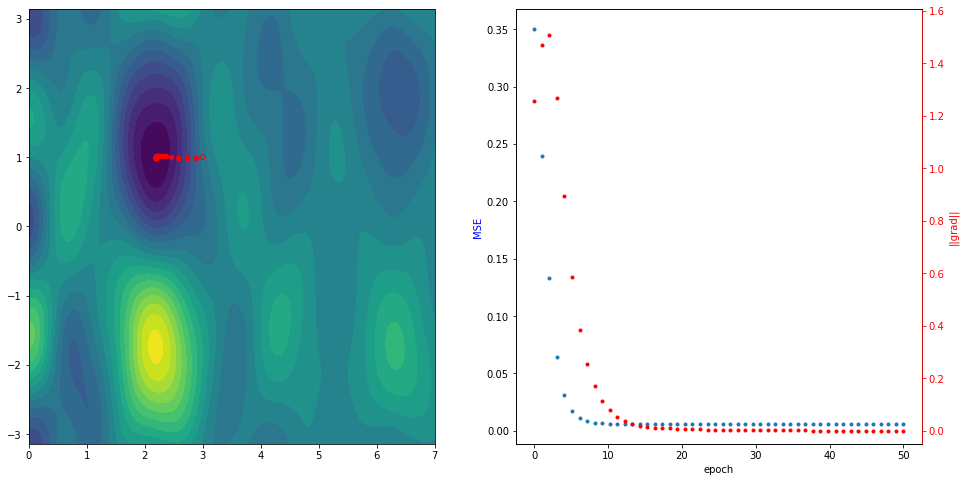

In [12]:
fig_gd

Abowe we have a working "plain vanilla" implementation of gradient descent. However a big drawback of this method is that the time for one iteration is proportional to the size of the training data set. This is not a problem for our data set, but soon our data will grow much bigger. 

## Stochastic gradient descent

This behaviour stems from the fact that gradient is calculated as a sum over the whole data set

$\newcommand{\b}[1]{\mathbf{#1}}$
$\newcommand{\grad}{\operatorname{grad}}$
$$\sum_{i=0}^{N-1} \grad_\textbf{w}  L(\b{y}_i,\b{x}_i|\b{w}) 
$$

$$\sum_{i=0}^{N-1} \grad_\textbf{w}  L(\b{y}_i,\b{x}_i|\b{w}) \approx \left\langle \grad_\textbf{w}  L(\b{y}_i,\b{x}_i|\b{w}) \right\rangle
$$

As you may recall from theory of probability  and statistics this sum is an approximation of the  real loss averaged over the whole unknow distribution. When $N$ becomes very large, we can sacrifice some precision by taking only a subset of the data to calculate gradient.  

This is illustrated below. Instead of taking the whole data sample, we draw smaller *batches* from it. We calculate the gradient over this batch. The red arrows represent gradient batches, and the blue arrow sample gradient. 

To draw batches we use function `random.choice(sample_size, batch_size)` that draws `batch_size` numbers from range (0,sample_size-1) without replacement  and returns an array containing them. This array is then used to index the original data sample. This is called "fancy indexing" in numpy. 

In [23]:
p=(3,1)
sample_size = 100
batch_size = 25
fig, ax = plt.subplots(1,2, figsize=(12,6))
g  = grad(data[:sample_size,0], data[:sample_size,1],*p)
ax[0].set_xlim(-3,3);
ax[0].set_ylim(-3,3);  
ax[0].arrow(0,0,g[0],g[1],color='blue', width=0.01, head_width=0.05, length_includes_head=True)
ax[1].set_xlim(-1.2,1.2);
ax[1].set_ylim(-1.2,1.2);   
ng = g/np.linalg.norm(g)
ax[1].arrow(0,0, ng[0], ng[1],color='blue', width=0.01, head_width=0.05, length_includes_head=True)
for i in range(12):
    batch_i = np.random.choice(sample_size, batch_size)
    g=grad(data[batch_i,0], data[batch_i,1],*p)
    ax[0].arrow(0,0,g[0],g[1],color='red', width=0.01, head_width=0.05, length_includes_head=True)
    ng = g/np.linalg.norm(g)
    ax[1].arrow(0,0,ng[0],ng[1],color='red', width=0.01, head_width=0.05, length_includes_head=True)
plt.close()    

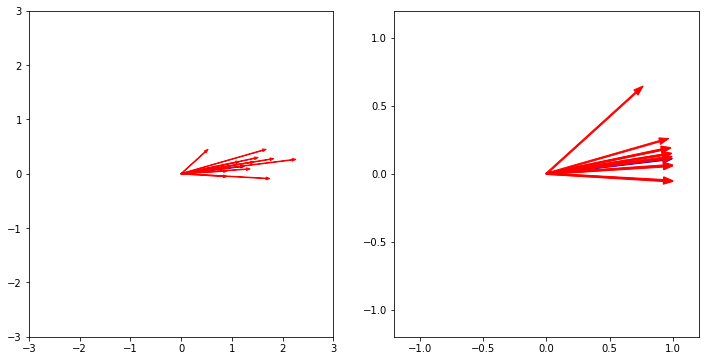

In [24]:
fig

The figure on the left show the gradients, on the right we display same gradients but normalized to better compare their directions. 

As you can see the gradients fluctuate, but point more or less in the same direction. The fluctuations are getting smaller when the sample and batch size get bigger. Please experiment with this number and see it yourself. The biggest possible sample size is 1000.

Below we take first four batches of data and display the MSE function for each of them. As you can see while differening they maintain the same structure. Again with bigger data sizes and bigger batches they will differ less.

Before proceeding further we make a copy of the data, as later we will change it "in place". 

In [15]:
sample_size = 100
data_copy = data[:sample_size].copy()
batch_size = 25

In [16]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
os = np.linspace(0, 2*np.pi, 400)
ts = np.linspace(-np.pi,np.pi,400)
otg = np.meshgrid(os,ts)
for i in range(4):    
    vg = mse(fitf_tensor, 
             data_copy[i*batch_size:(i+1)*batch_size,0], 
             data_copy[i*batch_size:(i+1)*batch_size,1], otg[0], otg[1])
    ax.reshape(-1)[i].contourf(otg[0], otg[1],vg, levels=20)
plt.close()    

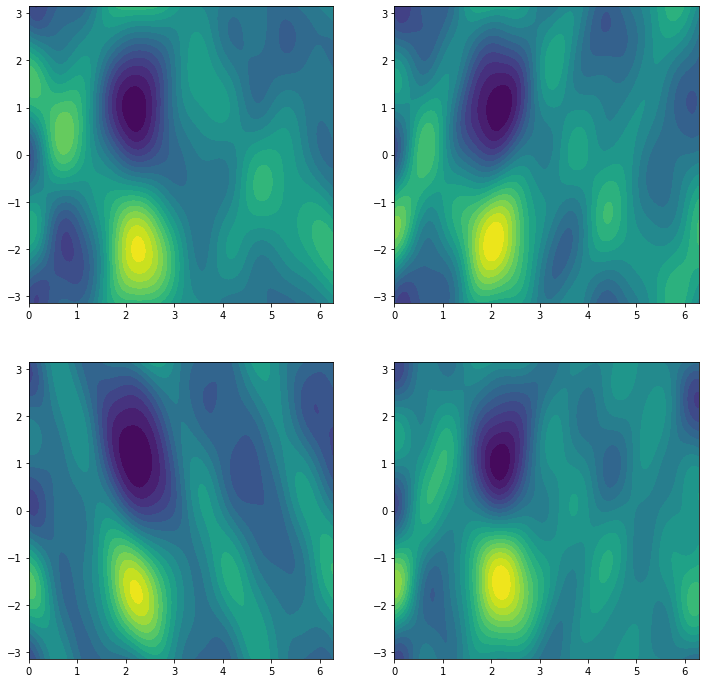

In [17]:
fig

Below we implement "plain vanilla" stochastics gradient descent (SGD). In each iteration we first shufle randomly the data and then split it into batches using function `array_split`. The for each  batch we calculate the gradient and update the parameters accordingly. That way for a single iteration we can get many more parameters updates then in simple gradient descent. This can be seen on the righthand side plot.

In [18]:
fig, ax =  plt.subplots(1,2,figsize=(16,8))
ax[0].contourf(otg[0], otg[1],vg, levels=20)
p =[3, 1]
ax[0].scatter([p[0]], [p[1]],c='none', s=20, edgecolor='red')
eta = 0.1
trajectory_list=[]
n_batches = (len(data_copy)+batch_size-1)//batch_size
batches = np.array_split(data_copy,n_batches)

n_iter = 50
for i in range(n_iter):
    np.random.shuffle(data_copy)
    for b in batches:
        g = grad(b[:,0], b[:,1], p[0], p[1])
        p -= eta*g
        trajectory_list.append(np.concatenate((g,p,[mse(fitf,rxs, rys,*p)])))
        ax[0].scatter([p[0]], [p[1]],c='red', s=20, edgecolor='red')
trajectory_sgd=np.stack(trajectory_list)
utils.plot_grad_and_trajectory(ax[1], trajectory_sgd, n_batches)
ax[1].set_xlabel("epoch");
plt.close()

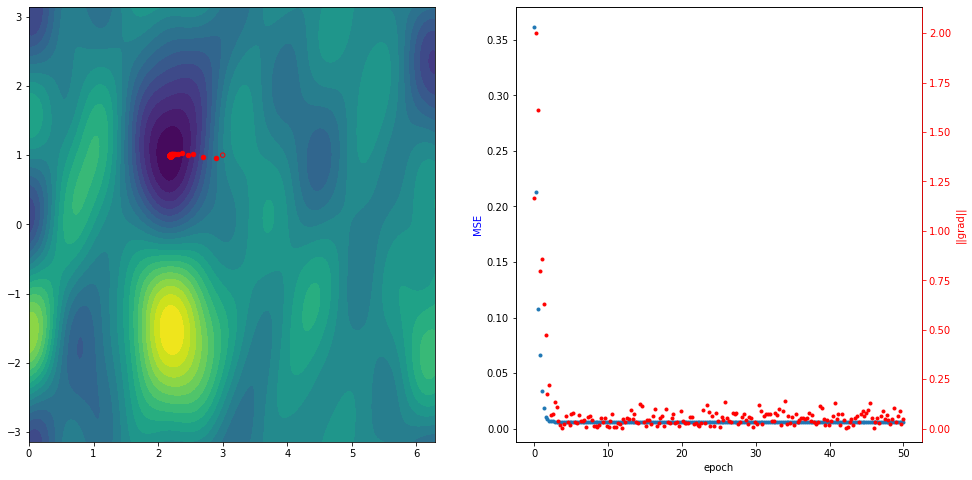

In [19]:
fig

In the gradient fluctuations you can clearly see the stochastic part of the algorith. Again those fluctuations will be smaller for bigger batch sizes.

A you can see comparing this to Gradient descent

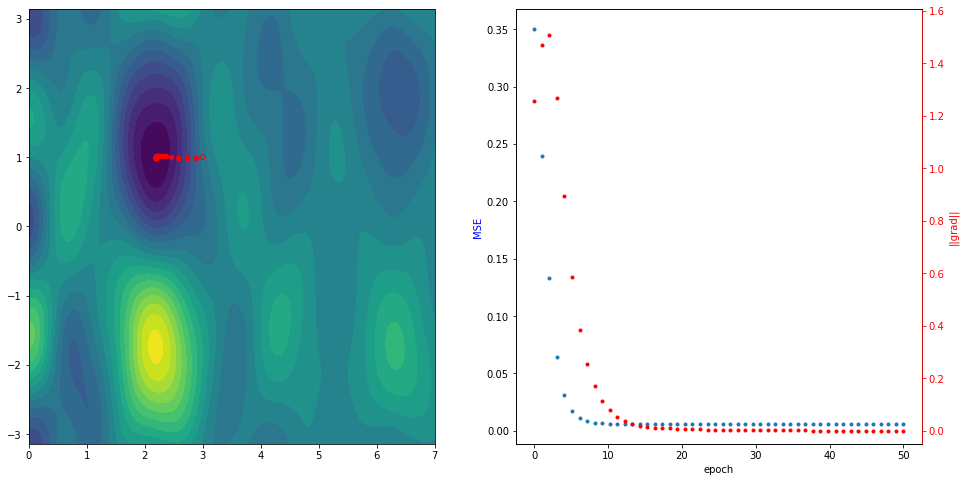

In [20]:
fig_gd

 SGD algorithm converges more quickly. This can be better seen in the plot below. The horizontal  axis unit is one epoch. That is one pass over all data. The stochastic gradients descent makes more steps in one epoch in approximately same time as  gradient descent makes one step. 

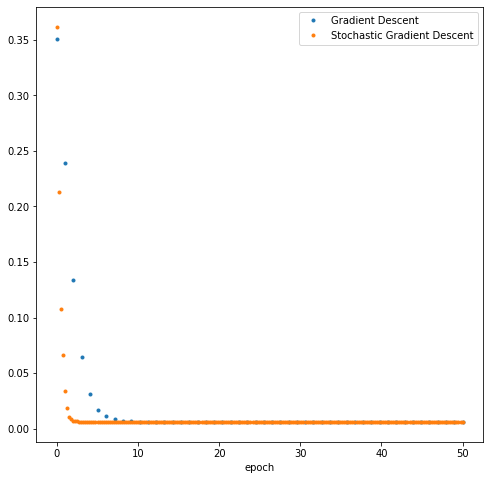

In [21]:
fig_comp , ax = plt.subplots(figsize=(8,8))
utils.plot_trajectory(ax, trajectory_gd,1, label="Gradient Descent")
utils.plot_trajectory(ax,trajectory_sgd, n_batches, label="Stochastic Gradient Descent")
ax.legend()
ax.set_xlabel("epoch");